# HW2 - Part 2

I generate $n=100$ $(x_i,y_i)$ samples for $i=1,2,...,100$ following the given direction of $x_i\sim N(0,1)$ and the form of $f$, and fit the data using the standard nonparametric GP model.

Specifically,

$Y_i \sim N(\theta_t, \sigma^2)$

$\theta \sim GP(\mu(t)=\mu, cov(t_1,t_2)=\tau^2 exp(-\phi |t_1 - t_2|^\alpha))$, i.e. the mean function is constant.

$\sigma^2 \sim Inv.gamma(a_\sigma, b_\sigma)$

$\mu \sim N(a_\mu, b_\mu)$

$\tau^2 \sim Inv.gamma(a_\tau, b_\tau)$

$\phi \sim Unif(0, b_\phi)$

and with a fixed $\alpha$. Note that the space of $\phi$ is not discretized here.

In the following 5 fitting result, I want to explore effects of
- the prior of $\phi$,
- the $\alpha$,
- the number of sample size $n$, and
- the prior of $\tau^2$.

Let me fix all the less interesting parameters: $a_\sigma=1$, $b_\sigma=1$, $a_mu=0$, and $b_\mu=1$.

The next two classes show the essential parts of Gibbs sampler for posterior samples, and posterior path simulator using the posterior samples.

In [ ]:
import numpy as np
from scipy.stats import norm as sp_norm
from scipy.stats import multivariate_normal as sp_mvn
from scipy.stats import invgamma as sp_invgam

import matplotlib.pyplot as plt
from pyBayes.MCMC_Core import MCMC_Gibbs, MCMC_MH, MCMC_Diag
from pyBayes.util_MCMC_proposal import unif_proposal_log_pdf, unif_proposal_sampler


#generate data
np.random.seed(20250212)
n_sample_size = 100
x_data = sp_norm.rvs(loc=0, scale=1, size=n_sample_size)
y_data = 0.3+0.4*x_data+0.5*np.sin(2.7*x_data)+1.1/(1+x_data**2) + sp_norm.rvs(loc=0, scale=0.2, size=n_sample_size)


class gaussian_process_post(MCMC_Gibbs):
    """
    == standard setting ==
    t = x_i : 1-dim
    y_t : 1-dim
    y_t ~ N(theta_t, sigma^2), iid
    theta ~ GP(mean(t)=mu, cov(t1,t2)= power-exp(tau, phi, alpha)
    and
    sigma2 ~ inv.gam(a_sigma,b_sigma)
    mu ~ N(a_mu, b_mu)
    tau2 ~ inv.gam(a_tau, b_tau)
    phi ~ unif(0, b_phi)
    alpha is fixed as a hyperparameter
    """
    def __init__(self, initial, t_time_idx, y_data, hyperparam_dict=None):
        #param
        # 0      1       2   3     4--->5
        #[theta, sigma2, mu, tau2, phi, H-inv]
        self.t_time_idx = t_time_idx #np array
        self.y_data = y_data #np array
        self.n = len(y_data)

        #hyperparamters
        if hyperparam_dict is None:
            self.hyper_a_sigma = 1
            self.hyper_b_sigma = 1
            self.hyper_a_mu = 0
            self.hyper_b_mu = 1
            self.hyper_a_tau = 1
            self.hyper_b_tau = 1
            self.hyper_b_phi = 20 #be careful!
            self.hyper_alpha = 2 #be careful!
        else:
            self.hyper_a_sigma = hyperparam_dict["a_sigma"]
            self.hyper_b_sigma = hyperparam_dict["b_sigma"]
            self.hyper_a_mu = hyperparam_dict["a_mu"]
            self.hyper_b_mu = hyperparam_dict["b_mu"]
            self.hyper_a_tau = hyperparam_dict["a_tau"]
            self.hyper_b_tau = hyperparam_dict["b_tau"]
            self.hyper_b_phi = hyperparam_dict["b_phi"]
            self.hyper_alpha = hyperparam_dict["alpha"]

        self.MC_sample = []
        initial = initial + [self.make_inv_H_corr_mat(initial[4])]
        self.MC_sample.append(initial)
        
        self.phi_accept_counter = 0

    def corr_function_power_exp(self, t1, t2, phi):
        return np.exp(-phi * (np.abs(t1-t2)**self.hyper_alpha))

    def make_inv_H_corr_mat(self, phi, log_det=False):
        corr_mat = np.array([[self.corr_function_power_exp(t1, t2, phi) for t1 in self.t_time_idx] for t2 in self.t_time_idx])
        corr_mat = corr_mat + np.identity(self.n)*0.01
        L_chol = np.linalg.cholesky(corr_mat)
        L_inv = np.linalg.inv(L_chol)
        inv_mat = np.dot(L_inv.T, L_inv)
        inv_mat_logdet = -np.sum(np.log(L_chol.diagonal()))
        if log_det:
            return (inv_mat, inv_mat_logdet)
        else:
            return inv_mat

    def sampler(self, **kwargs):
        last = self.MC_sample[-1]
        new = self.deep_copier(last)
        new[0] = np.array(new[0])
        new[5] = np.array(new[5])
        #update new
        new = self.full_conditional_sampler_theta(new)
        new = self.full_conditional_sampler_sigma2(new)
        new = self.full_conditional_sampler_mu(new)
        new = self.full_conditional_sampler_tau2(new)
        new = self.full_conditional_sampler_phi(new)
        self.MC_sample.append(new)

    def full_conditional_sampler_theta(self, last_param):
        new_sample = [x for x in last_param]
        #param
        # 0      1       2   3     4--->5
        #[theta, sigma2, mu, tau2, phi, H-inv]
        #update new
        new_cov = np.linalg.inv(np.identity(self.n)/last_param[1] + last_param[5]/last_param[3])
        new_mean = new_cov @ (self.y_data/last_param[1] + last_param[2]*(last_param[5] @ np.ones((self.n, )))/last_param[3]) 
        new_theta = sp_mvn.rvs(mean = new_mean, cov = new_cov)
        new_sample[0] = new_theta
        return new_sample
    
    def full_conditional_sampler_sigma2(self, last_param):
        new_sample = [x for x in last_param]
        #param
        # 0      1       2   3     4--->5
        #[theta, sigma2, mu, tau2, phi, H-inv]
        #update new
        new_a = self.hyper_a_sigma + 0.5*self.n
        new_b = self.hyper_b_sigma + 0.5*np.sum((self.y_data - last_param[0])**2)
        new_sigma2 = sp_invgam.rvs(a = new_a, scale = new_b) #check if it is new_b or 1/new_b (maybe new_b)
        new_sample[1] = new_sigma2
        return new_sample
    
    def full_conditional_sampler_mu(self, last_param):
        new_sample = [x for x in last_param]
        #param
        # 0      1       2   3     4--->5
        #[theta, sigma2, mu, tau2, phi, H-inv]
        #update new
        btm = last_param[3] + self.hyper_b_mu * np.ones((1, self.n)) @ last_param[5] @ np.ones((self.n, 1))
        new_var = last_param[3] * self.hyper_b_mu / btm
        new_mean = (last_param[3] * self.hyper_a_mu + self.hyper_b_mu * last_param[0] @ last_param[5] @ np.ones((self.n, 1))) / btm
        new_mu = sp_norm.rvs(loc = new_mean, scale = new_var**0.5)
        new_sample[2] = new_mu
        return new_sample

    def full_conditional_sampler_tau2(self, last_param):
        new_sample = [x for x in last_param]
        #param
        # 0      1       2   3     4--->5
        #[theta, sigma2, mu, tau2, phi, H-inv]
        #update new
        quad_one_term = np.reshape(last_param[0] - last_param[2], (1, self.n))
        new_a = self.hyper_a_tau + 0.5 * self.n
        new_b = self.hyper_b_tau + 0.5 * quad_one_term @ last_param[5] @ np.transpose(quad_one_term)
        new_tau2 = sp_invgam.rvs(a = new_a, scale = new_b) #check if it is new_b or 1/new_b (maybe new_b)
        new_sample[3] = new_tau2
        return new_sample
    
    def full_conditional_sampler_phi(self, last_param):
        new_sample = [x for x in last_param]
        #param
        # 0      1       2   3     4--->5
        #[theta, sigma2, mu, tau2, phi, H-inv]
        #update new
        #param
        #0                  1     2
        #F0_xi[loc, scale], DP_a, eta
     
        def phi_log_pdf_posterior(phi):
            phi = phi[0]
            H_inv_mat, H_inv_logdet = self.make_inv_H_corr_mat(phi, log_det=True)
            
            quad_one_term = np.reshape(last_param[0] - last_param[2], (1, self.n))
            log_val = -np.log(self.hyper_b_phi)
            log_val += (0.5*H_inv_logdet)
            log_val -= (quad_one_term @ H_inv_mat @ np.transpose(quad_one_term)/(2*last_param[3]))
            return log_val

        phi_proposal_window = self.hyper_b_phi/3
        def phi_proposal_log_pdf(from_smpl, to_smpl):
            phi_proposal_log_pdf = unif_proposal_log_pdf(from_smpl, to_smpl, 
                                                          lower_lim=0, upper_lim=self.hyper_b_phi, window=phi_proposal_window)
            return phi_proposal_log_pdf
        def phi_proposal_sampler(from_smpl):
            phi_proposal_sample = unif_proposal_sampler(from_smpl, 
                                                         lower_lim=0, upper_lim=self.hyper_b_phi, window=phi_proposal_window)
            return phi_proposal_sample

        mh_inst = MCMC_MH(phi_log_pdf_posterior, phi_proposal_log_pdf, phi_proposal_sampler, [last_param[4]])
        mh_inst.generate_samples(2, verbose=False)
        new_phi = mh_inst.MC_sample[-1][0]
        if new_phi != last_param[4]:
            self.phi_accept_counter += 1
        new_sample[4] = new_phi
        new_sample[5] = self.make_inv_H_corr_mat(new_phi)
        return new_sample
    
    

class post_gaussian_process_simulator:
    def __init__(self, post_sample, hyper_alpha, x_data):
        #param
        # 0      1       2   3     4--->5
        #[theta, sigma2, mu, tau2, phi, H-inv]
        self.post = post_sample
        self.grid = np.array([x/5 - 3 for x in range(0, 30)])
        self.m = len(self.grid)
        self.n = len(post_sample[0][0])
        
        self.x_data = x_data
        self.hyper_alpha = hyper_alpha

    def cov_function_power_exp(self, t1, t2, phi):
        return np.exp(-phi * np.abs(t1-t2)**self.hyper_alpha)

    def run(self, sample_idx):
        post_i = self.post[sample_idx]
        Hstar = np.array([[self.cov_function_power_exp(tn, tm, post_i[4]) for tn in self.x_data] for tm in self.grid])
        Htilde = np.array([[self.cov_function_power_exp(t1, t2, post_i[4]) for t1 in self.grid] for t2 in self.grid])
        # print(self.Hstar.shape) #m x n
        pred_mean = post_i[2] * np.ones(self.m) + Hstar @ post_i[5] @ (post_i[0] - post_i[2])

        # # Compute ABA^T
        # ABA_T = np.dot(A, np.dot(B, A.T))
        # # Symmetrize the resulting matrix
        # ABA_T_sym = (ABA_T + ABA_T.T) / 2
        # hhh = np.dot(Hstar, np.dot(post_i[5], Hstar.T))
        # hhh_sym = (hhh + hhh.T) / 2
        
        # return pred_mean
    
        hhh_sym = Hstar @ post_i[5] @ np.transpose(Hstar)
        pred_cov = post_i[3] * (Htilde - hhh_sym)
        path = sp_mvn.rvs(mean = pred_mean, cov = (pred_cov + 0.1*np.identity(self.m)))
        return path#, pred_mean
        

## 1. reference case under $\alpha=2$

As a reference case, I will use

- $a_\tau = b_\tau = 1$,
- $b_\phi = 20$, and
- $\alpha = 2$.

I generate 800 samples from the Gibbs sampler and cut the first 100 as a burn in period.
Gibbs sampler's initial points are $\bm{\theta}=0, \sigma^2=1, \mu=0, \tau^2=1$, and $\phi=2$.
It is found that the sampler is not very senstivie to the initial value of the Gibbs sampler.
Generally, the convergence is quite quick.

In [2]:

gibbs_initial_param = [np.zeros(n_sample_size), 1, 0, 1, 2] #no H_inv here
hyperparam_dict_1={
    "a_sigma":1,
    "b_sigma":1,
    "a_mu":0,
    "b_mu":1,
    "a_tau":1,
    "b_tau":1,
    "b_phi":20,
    "alpha":2,
}
inst_1 = gaussian_process_post(gibbs_initial_param, x_data, y_data, hyperparam_dict_1)
iter_sampler_num = 800
inst_1.generate_samples(iter_sampler_num)

estimated running time:  1.0 min  59.424415588378906 sec
iteration 500 / 800
iteration 800 / 800  done! (elapsed time for execution:  2.0 min  1.2237584590911865 sec)


The next plot shows the $\{(x_i, y_i)\}$ data pairs (blue dots) and posterior $\{\theta_i\}$ path at the 800th iteration of Gibbs sampler at $\{x_i\}$ for $i=1,2,...,n=100$.
We can observe that the fitted $\theta_i$ illustrates the data quite well.
We can think of the mean $\{\theta_i\}$ and its credible interval at each $x_i$, but let me skip it.

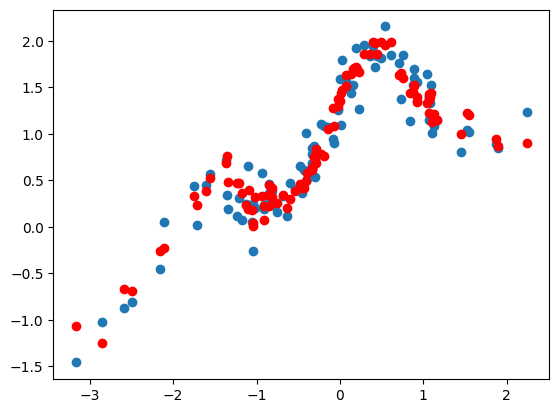

In [3]:
plt.scatter(x_data, y_data)
plt.scatter(x_data, inst_1.MC_sample[iter_sampler_num-1][0], color="red")
plt.show()

Traceplots for $\sigma^2, \mu, \tau^2$, and $\phi$ after burn-in period look fine even if the mixing for $\phi$ is not very perfect.
We can see that in posterior, $\sigma^2$ is near $0.06$, $\mu$ is near $0.5$, $\tau^2$ is near $0.5$.


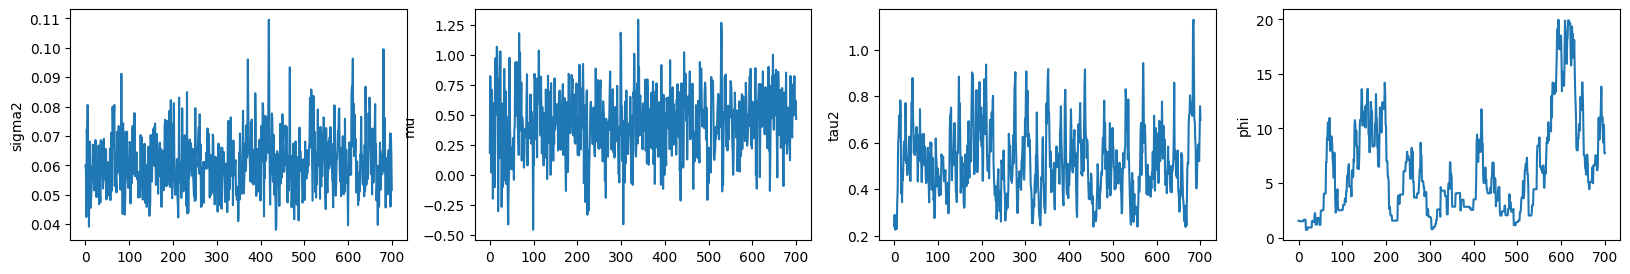

In [4]:
diag_inst_1 = MCMC_Diag()
diag_inst_1.set_mc_samples_from_list([x[1:5] for x in inst_1.MC_sample])
diag_inst_1.set_variable_names(["sigma2","mu","tau2","phi"])
diag_inst_1.burnin(100)
diag_inst_1.show_traceplot((1,4))

The next plot shows five $\tilde{\theta}$ paths predicted on even grid of $[-3,3]$ based on five posterior samples. I choose 720th, 740th, 760th, 780th, and 800th Gibbs samples and simulate a path at each selected posterior sample (five color curves).
The data points are added again as blue dots.

We can calculate all predicted sample paths based on all posterior samples and make a pointwise summary (mean, credible intervle, etc).
However, to see the characteristic of paths themselves instead of their average, let me look at the five cases only.


Paths are smooth, because we use $\alpha=2$.
However, the local correlation is not very strong, because the inverse of range of dependence $\phi$ is quite large in posterior.

Paths have some variability, especially in the area that the dataset is not very dense.
For example, on $[-1,1]$, all paths are moving together, but in the boundary like $[2,3]$, paths get dispersed.
And even in the dense area, paths sometimes go outside further than data points.
It might be an effect of vague prior for $\tau^2$.

I will take this result as reference to observe the prior effect to posterior under following four cases.

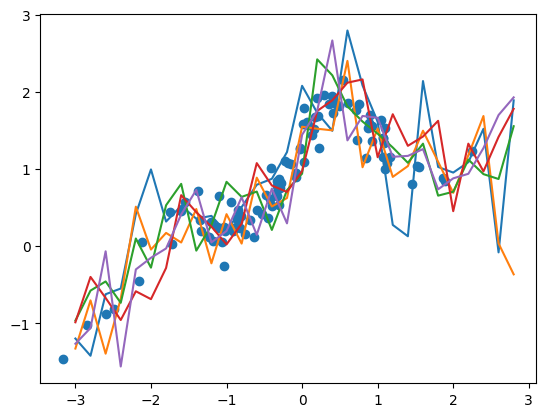

In [5]:
sim_inst_1 = post_gaussian_process_simulator(inst_1.MC_sample, hyper_alpha=2, x_data=x_data)
plt.scatter(x_data, y_data)
plt.plot(sim_inst_1.grid, sim_inst_1.run(719))
plt.plot(sim_inst_1.grid, sim_inst_1.run(739))
plt.plot(sim_inst_1.grid, sim_inst_1.run(759))
plt.plot(sim_inst_1.grid, sim_inst_1.run(779))
plt.plot(sim_inst_1.grid, sim_inst_1.run(799))
plt.show()

## 2. Very small upper-bound for $\phi$

Now, I set $b_\phi=2$. In other words, $\phi \sim Unif(0, 2)$.
Intentionally, I put a stronger belief that the range of dependency $1/\phi$ is longer, compared to the refernce case above.

In [6]:
gibbs_initial_param = [np.zeros(n_sample_size), 1, 0, 1, 2] #no H_inv here
hyperparam_dict_2={
    "a_sigma":1,
    "b_sigma":1,
    "a_mu":0,
    "b_mu":1,
    "a_tau":1,
    "b_tau":1,
    "b_phi":2, #<<---
    "alpha":2,
}
inst_2 = gaussian_process_post(gibbs_initial_param, x_data, y_data, hyperparam_dict_2)
iter_sampler_num = 800
inst_2.generate_samples(iter_sampler_num)

estimated running time:  1.0 min  56.73311424255371 sec
iteration 500 / 800
iteration 800 / 800  done! (elapsed time for execution:  1.0 min  58.96116614341736 sec)


The next plot shows the data (blue dots) and 800th sample of $\phi$ from the Gibbs sampler (red dots).
Fitting looks ok.

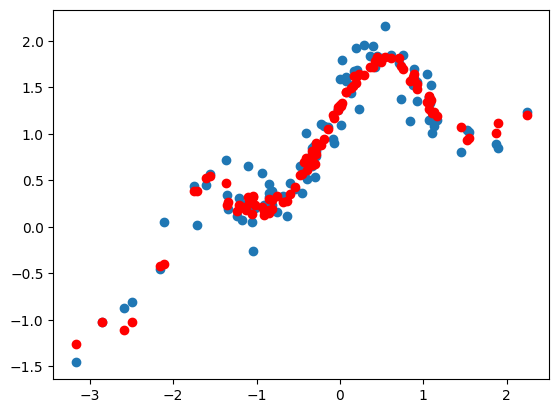

In [7]:
plt.scatter(x_data, y_data)
plt.scatter(x_data, inst_2.MC_sample[iter_sampler_num-1][0], color="red")
plt.show()

Traceplots are here.
We can see that $\phi$ cannot be larger than $2$.
The other three paramters converge to the similar values with the reference case.

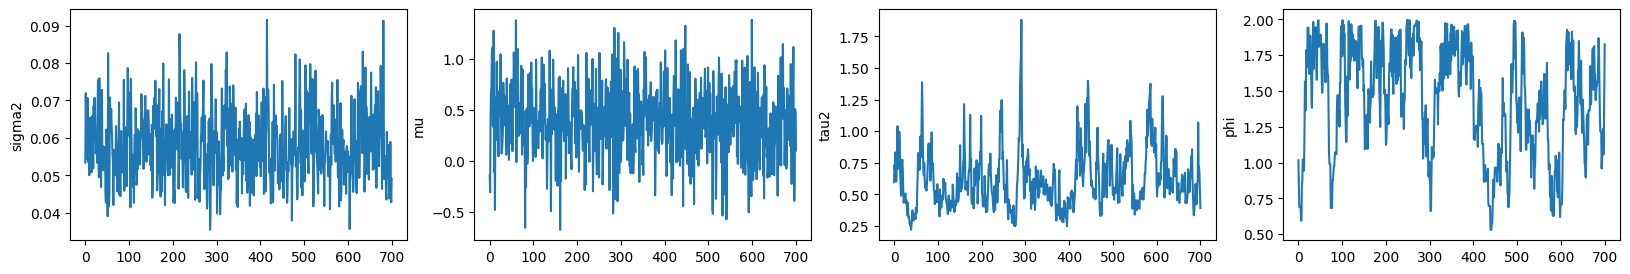

In [8]:
diag_inst_2 = MCMC_Diag()
diag_inst_2.set_mc_samples_from_list([x[1:5] for x in inst_2.MC_sample])
diag_inst_2.set_variable_names(["sigma2","mu","tau2","phi"])
diag_inst_2.burnin(100)
diag_inst_2.show_traceplot((1,4))

Next plot shows five predicted $\tilde{\theta}$ paths on the grid that I used.
The characteristic of predicted paths is quite different; becuase of the effect of small $\phi$, the local correlation becomes stronger.
As a result, the paths look much more smoother than of the refernce case.
We have to say that the prior effect of $\phi$ is very strong.
We need to take care of choosing appropriate prior for $\phi$.

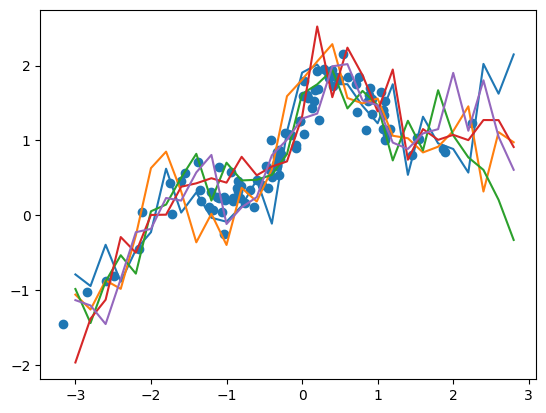

In [9]:
sim_inst_2 = post_gaussian_process_simulator(inst_2.MC_sample, hyper_alpha=2, x_data=x_data)
plt.scatter(x_data, y_data)
plt.plot(sim_inst_2.grid, sim_inst_2.run(719))
plt.plot(sim_inst_2.grid, sim_inst_2.run(739))
plt.plot(sim_inst_2.grid, sim_inst_2.run(759))
plt.plot(sim_inst_2.grid, sim_inst_2.run(779))
plt.plot(sim_inst_2.grid, sim_inst_2.run(799))
plt.show()

## 3. Different smoothness, under $\alpha=1$

Here I use Gaussian covariance function instead of exponential covariance function.
I keep the other paramters the same with the reference case, and use the same dataset.

In [11]:
gibbs_initial_param = [np.zeros(n_sample_size), 1, 0, 1, 2] #no H_inv here
hyperparam_dict_3={
    "a_sigma":1,
    "b_sigma":1,
    "a_mu":0,
    "b_mu":1,
    "a_tau":1,
    "b_tau":1,
    "b_phi":20,
    "alpha":1, #<-----
}
inst_3 = gaussian_process_post(gibbs_initial_param, x_data, y_data, hyperparam_dict_3)
iter_sampler_num = 800
inst_3.generate_samples(iter_sampler_num)

estimated running time:  2.0 min  1.2144660949707031 sec
iteration 500 / 800
iteration 800 / 800  done! (elapsed time for execution:  2.0 min  3.2308743000030518 sec)


The next plot shows the data (blue dots) and 800th sample of $\phi$ from the Gibbs sampler (red dots).
We can observe that even the posterior $\{\theta_i\}$ is quite different.
Red dots are more scattered and jump more, compared to reference $\alpha=2$ case.

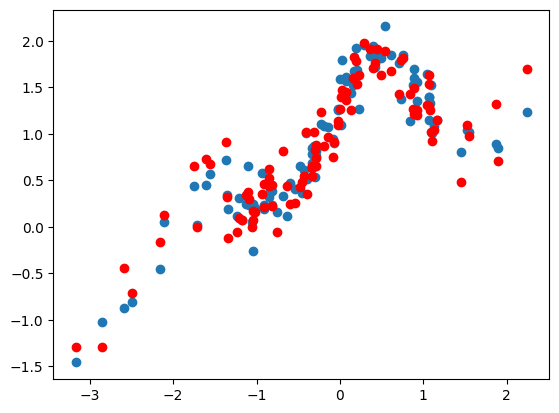

In [12]:
plt.scatter(x_data, y_data)
plt.scatter(x_data, inst_3.MC_sample[iter_sampler_num-1][0], color="red")
plt.show()

Convergence looks ok.
However, because we changed the power of covaraince, $\alpha$, I do not think we can compare values directly.
Their role may the same regardless of $\alpha$, but a specific size of the parameter values will not correspond the same level of amplitude, covaraince scaling, the range of dependency under different $\alpha$ s.
For example, even under the same prior $\phi\sim Unif(0,20)$ and same dataset, the posterior $\phi$s converge to very different values when $\alpha=2$ and $\alpha=1$.

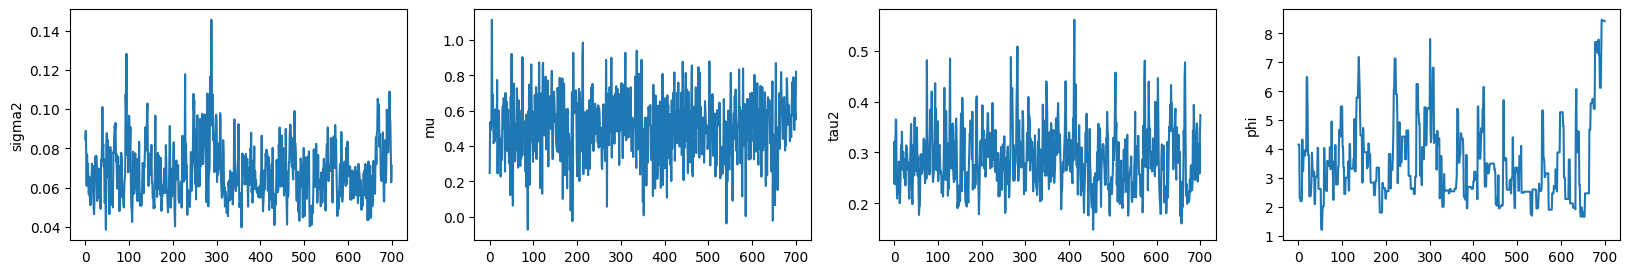

In [13]:
diag_inst_3 = MCMC_Diag()
diag_inst_3.set_mc_samples_from_list([x[1:5] for x in inst_3.MC_sample])
diag_inst_3.set_variable_names(["sigma2","mu","tau2","phi"])
diag_inst_3.burnin(100)
diag_inst_3.show_traceplot((1,4))

Finally, I predicted $\tilde{\theta}$ on the grid. 
Compared to the reference case, we can see bigger jumps much more frequently.
It shows that the paths are less smooth under this setting.

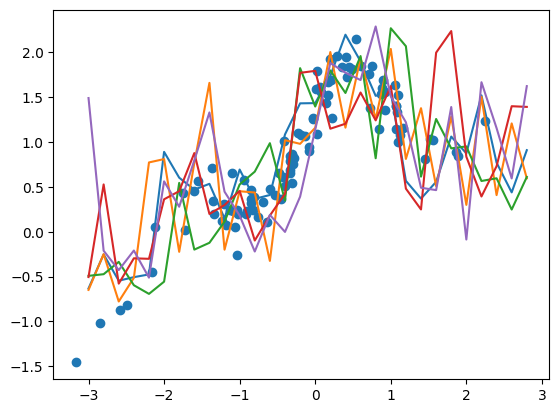

In [14]:
sim_inst_3 = post_gaussian_process_simulator(inst_3.MC_sample, hyper_alpha=1, x_data=x_data)
plt.scatter(x_data, y_data)
plt.plot(sim_inst_3.grid, sim_inst_3.run(719))
plt.plot(sim_inst_3.grid, sim_inst_3.run(739))
plt.plot(sim_inst_3.grid, sim_inst_3.run(759))
plt.plot(sim_inst_3.grid, sim_inst_3.run(779))
plt.plot(sim_inst_3.grid, sim_inst_3.run(799))
plt.show()

## 4. Different sample size, under $n=300$

I generated a new $n=200$ dataset, using the same structure.
With keeping all priors with the reference case, I draw samples from the Gibbs sampler.

In [17]:
np.random.seed(20250212)
n_sample_size_long = 200
x_data_long = sp_norm.rvs(loc=0, scale=1, size=n_sample_size_long)
y_data_long = 0.3+0.4*x_data_long+0.5*np.sin(2.7*x_data_long)+1.1/(1+x_data_long**2) + sp_norm.rvs(loc=0, scale=0.2, size=n_sample_size_long)

gibbs_initial_param = [np.zeros(n_sample_size), 1, 0, 1, 2] #no H_inv here
hyperparam_dict_4={
    "a_sigma":1,
    "b_sigma":1,
    "a_mu":0,
    "b_mu":1,
    "a_tau":1,
    "b_tau":1,
    "b_phi":20,
    "alpha":2,
}
inst_4 = gaussian_process_post(gibbs_initial_param, x_data_long, y_data_long, hyperparam_dict_4)
iter_sampler_num = 800
inst_4.generate_samples(iter_sampler_num)


estimated running time:  7.0 min  34.893287658691406 sec
iteration 500 / 800
iteration 800 / 800  done! (elapsed time for execution:  7.0 min  38.62989282608032 sec)


Note that the sampler running time gets 3.5 times longer than $n=100$ case.
Because GP fitting requires matrix inverting, the running time is not linear on $n$. (Its complexity is $O(n^3)$, maybe.)
Even if I use cholesky decomposition, it is still quite slow. Probably a better algorithm is possible.

The next plot shows the data (blue dots) and 800th sample of $\phi$ from the Gibbs sampler (red dots).
The behavior is much better compared to $n=100$, particularly near 0, where the data are dense.

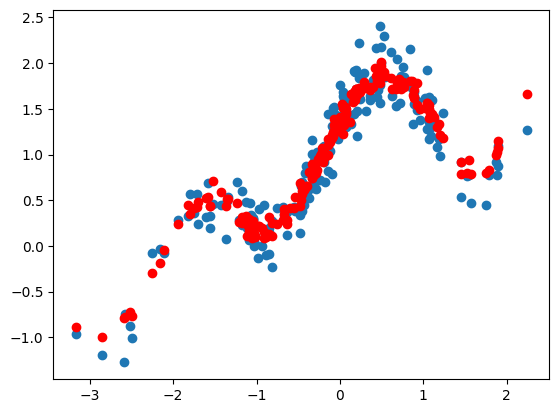

In [18]:
plt.scatter(x_data_long, y_data_long)
plt.scatter(x_data_long, inst_4.MC_sample[iter_sampler_num-1][0], color="red")
plt.show()

Convergence looks good. Variance of all four $\sigma^2, \mu, \tau^2$, and $\phi$ gets smaller compared to $n=100$ case, thanks to more amount of information.

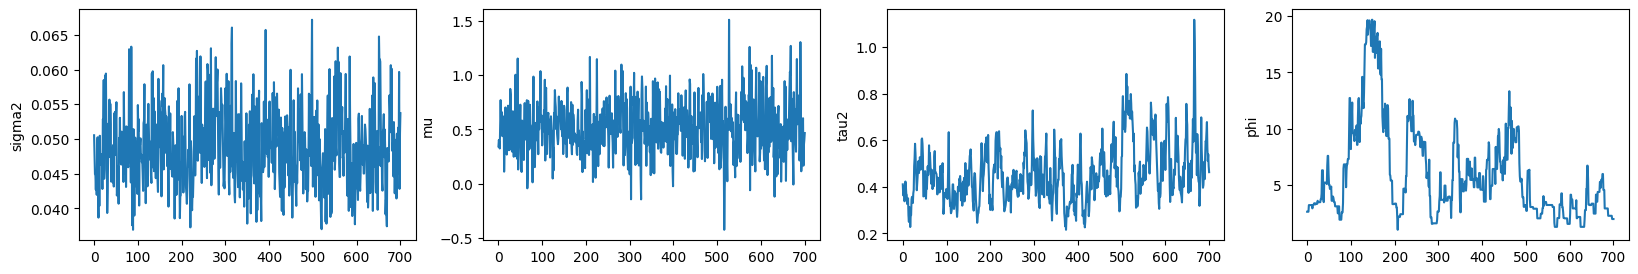

In [19]:
diag_inst_4 = MCMC_Diag()
diag_inst_4.set_mc_samples_from_list([x[1:5] for x in inst_4.MC_sample])
diag_inst_4.set_variable_names(["sigma2","mu","tau2","phi"])
diag_inst_4.burnin(100)
diag_inst_4.show_traceplot((1,4))

The dispersion of predicted sample paths of $\tilde{\theta}$ on the grid gets smaller es well.
Except for the boundaries, paths become closer to the observation.
Even if we use the same value of $\alpha=2$, the paths are improved a lot.

We can guess that the opposit situation will happen when $n$ gets small.

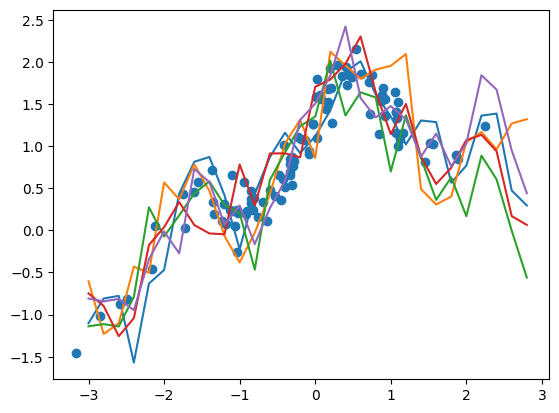

In [20]:
sim_inst_4 = post_gaussian_process_simulator(inst_4.MC_sample, hyper_alpha=2, x_data=x_data_long)
plt.scatter(x_data, y_data)
plt.plot(sim_inst_4.grid, sim_inst_4.run(719))
plt.plot(sim_inst_4.grid, sim_inst_4.run(739))
plt.plot(sim_inst_4.grid, sim_inst_4.run(759))
plt.plot(sim_inst_4.grid, sim_inst_4.run(779))
plt.plot(sim_inst_4.grid, sim_inst_4.run(799))
plt.show()

# 5. different hyperparameters about $\tau$

Finally, I choose more informative prior for $\tau^2$.
The density of $\tau$ is more concentrated near $20/(11-1)=2$ priori, compared to the reference case.

In [25]:
gibbs_initial_param = [np.zeros(n_sample_size), 1, 0, 1, 2] #no H_inv here
hyperparam_dict_5={
    "a_sigma":1,
    "b_sigma":1,
    "a_mu":0,
    "b_mu":1,
    "a_tau":11, #<-----
    "b_tau":20, #<-----
    "b_phi":20,
    "alpha":2, 
}
inst_5 = gaussian_process_post(gibbs_initial_param, x_data, y_data, hyperparam_dict_5)
iter_sampler_num = 800
inst_5.generate_samples(iter_sampler_num)

estimated running time:  1.0 min  53.962114334106445 sec
iteration 500 / 800
iteration 800 / 800  done! (elapsed time for execution:  2.0 min  0.12288451194763184 sec)


The scatterplot for the 800th $\{\theta\}$ sample is not very differnt from the reference case.

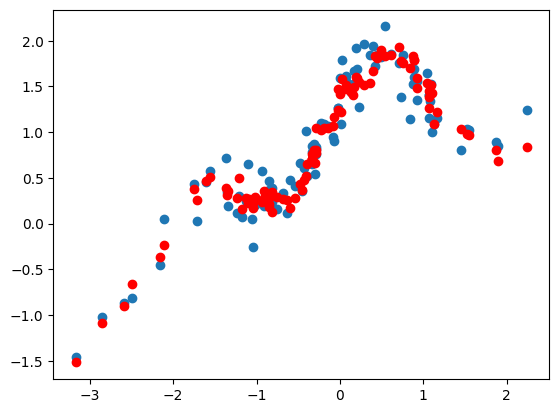

In [26]:
plt.scatter(x_data, y_data)
plt.scatter(x_data, inst_5.MC_sample[iter_sampler_num-1][0], color="red")
plt.show()

We can see that $\tau_^2$ is almost twice larger than the reference case.
The prior works for the parameter $\tau^2$ anyway.

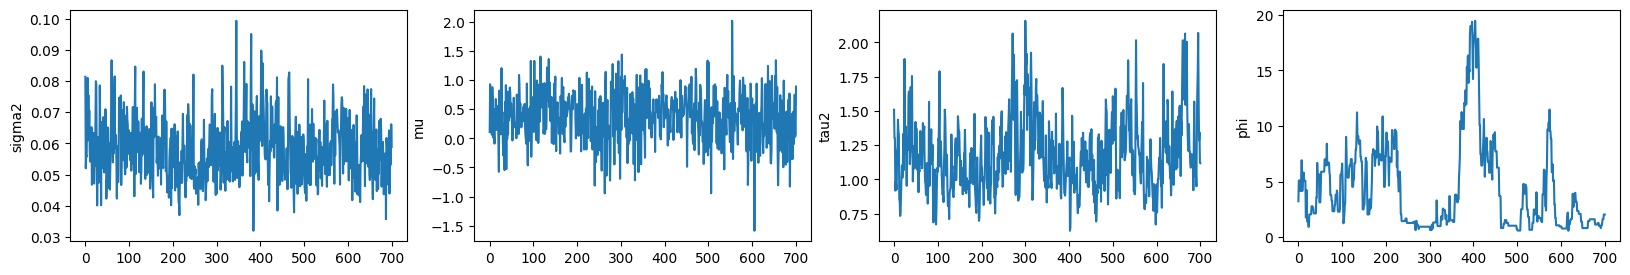

In [27]:
diag_inst_5 = MCMC_Diag()
diag_inst_5.set_mc_samples_from_list([x[1:5] for x in inst_5.MC_sample])
diag_inst_5.set_variable_names(["sigma2","mu","tau2","phi"])
diag_inst_5.burnin(100)
diag_inst_5.show_traceplot((1,4))

However, when we observe the predicted sample paths for $\tilde{\theta}$ in the next figure, it is hard to see any noticeable difference from the reference cases.
Probably it is because we look at only five paths.
But we can say that, compared to the effect of $\phi$ or $\alpha$, the prior effect for $\tau$ is small.

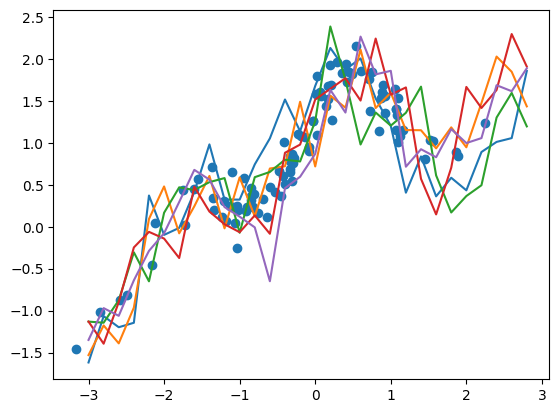

In [29]:
sim_inst_5 = post_gaussian_process_simulator(inst_5.MC_sample, hyper_alpha=2, x_data=x_data)
plt.scatter(x_data, y_data)
plt.plot(sim_inst_5.grid, sim_inst_5.run(719))
plt.plot(sim_inst_5.grid, sim_inst_5.run(739))
plt.plot(sim_inst_5.grid, sim_inst_5.run(759))
plt.plot(sim_inst_5.grid, sim_inst_5.run(779))
plt.plot(sim_inst_5.grid, sim_inst_5.run(799))
plt.show()